# Test the neural network for different disorder Configurations

#### Imports

In [7]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn
from src.training.utils_analysis import test_models_unet

#### Data

In [40]:
hs=[2.4,3.6,5.44,7.2,8.4]
models_name=[f'2nn_ising/h_{h}_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock' for h in hs]
ls=[16,24,32,48,64,128]
data_path=[[f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_{h}_h_100_n.npz' for l in ls] for h in hs]

In [41]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i] for j in range(len(data_path[i]))],data_path=data_path[i])
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=16521
R_square_test=0.9999998807907104 for 2nn_ising/h_2.4_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=7.872318811147687e-06 std(de)=5.62362218645044e-06
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1

#### Accuracy

$R^2$

6


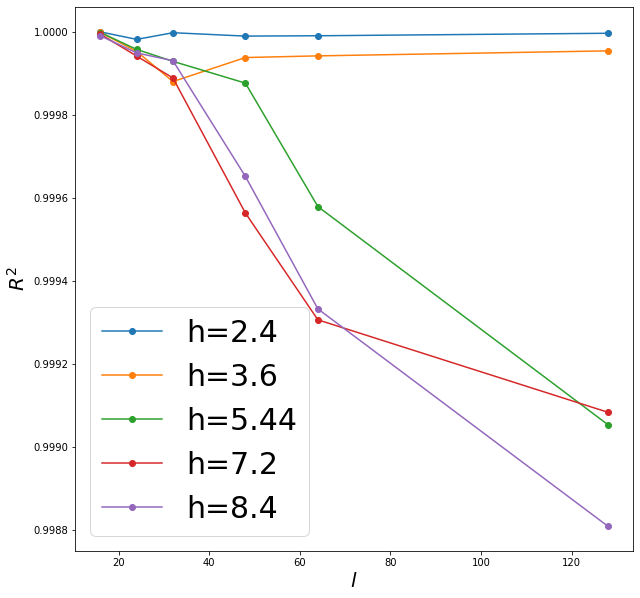

In [42]:
print(len(rs[i]))
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'h={hs[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

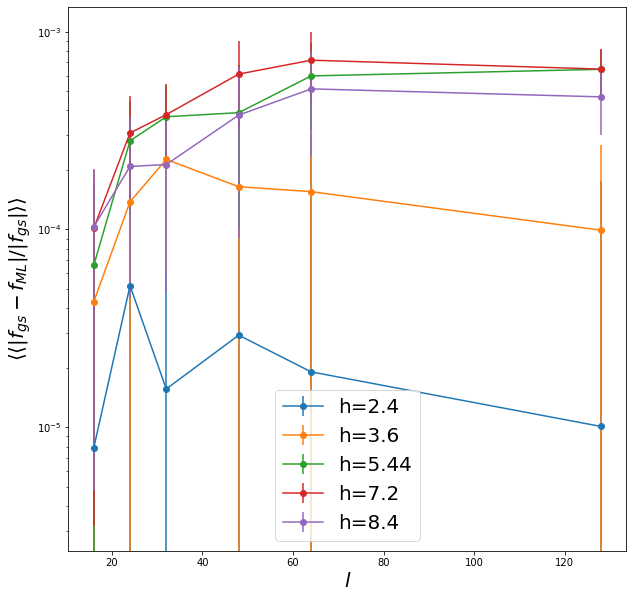

In [54]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'h={hs[i]}')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [55]:
ndata=100
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[j][i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

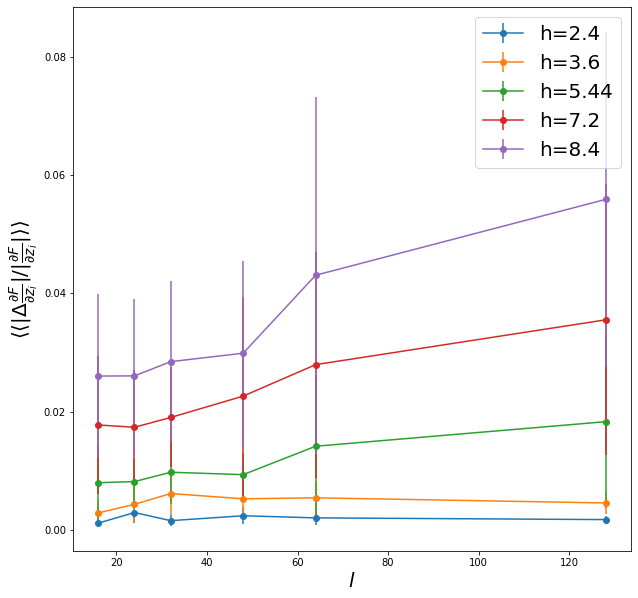

In [53]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'h={hs[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()